In [14]:
import pandas as pd
import numpy as np
import joblib as jb
import math

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [15]:
def root_mean_squared_error(y_test, preds):
    return math.sqrt(mean_squared_error(y_true=y_test, y_pred=preds))    

### Generate labels

In [16]:
month_to_predict_1 = 33
month_to_predict_2 = 32
month_to_predict_3 = 31
month_to_predict_4 = 30

In [17]:
items = pd.read_csv("data/items.csv")
items_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
shops = pd.read_csv("data/shops.csv")

In [18]:
df = pd.merge(items, items_categories, on="item_category_id", how="inner")
df = pd.merge(df, sales_train, on="item_id", how="inner")
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [19]:
def label_df(df, month_to_label):
    to_label = df[df["date_block_num"] == month_to_label]
    
    print("Before deleting negative item_cnt_day:", len(to_label))
    to_label = to_label[to_label["item_cnt_day"] > 0]
    print("After deleting negative item_cnt_day", len(to_label))
    
    labeled = to_label.groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum", "item_category_id":"max"}).reset_index().rename(columns={"item_cnt_day":"label"})
    
    print("Before taking 99th percentil of label:", len(labeled))
    labeled = labeled[labeled.label <= np.percentile(a=labeled["label"], q=99)]
    print("After taking 99th percentil of label:", len(labeled))    
    return labeled

In [20]:
labeled_1 = label_df(df, month_to_predict_1)

Before deleting negative item_cnt_day: 53514
After deleting negative item_cnt_day 53386
Before taking 99th percentil of label: 31521
After taking 99th percentil of label: 31218


In [21]:
labeled_2 = label_df(df, month_to_predict_2)

Before deleting negative item_cnt_day: 50588
After deleting negative item_cnt_day 50443
Before taking 99th percentil of label: 29652
After taking 99th percentil of label: 29382


In [22]:
labeled_3 = label_df(df, month_to_predict_3)

Before deleting negative item_cnt_day: 57029
After deleting negative item_cnt_day 56913
Before taking 99th percentil of label: 33472
After taking 99th percentil of label: 33180


In [23]:
labeled_4 = label_df(df, month_to_predict_4)

Before deleting negative item_cnt_day: 55549
After deleting negative item_cnt_day 55420
Before taking 99th percentil of label: 33515
After taking 99th percentil of label: 33181


In [24]:
print(len(labeled_1))
labeled_1.head()

31218


,shop_id,item_id,label,item_category_id
0,2,31,1.0,37
1,2,486,3.0,73
2,2,787,1.0,49
3,2,794,1.0,73
4,2,968,1.0,40


In [25]:
a = pd.read_csv("generated/features_train_4/features_shops.csv")
a.head()

,shop_id,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,items_sold_by_shop_last_7_months,items_sold_by_shop_last_8_months,items_sold_by_shop_last_9_months,items_sold_by_shop_last_10_months,items_sold_by_shop_last_11_months,items_sold_by_shop_last_12_months,items_sold_by_shop_last_13_months
0,0,48,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,41,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,59,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,890.0,748.0,899.0
3,3,57,670.0,708.0,687.0,741.0,729.0,972.0,1272.0,1013.0,760.0,883.0,878.0,749.0,811.0
4,4,60,791.0,815.0,797.0,955.0,966.0,1133.0,1886.0,1223.0,1148.0,1045.0,1330.0,1070.0,1163.0


#### Generate dataframe with features

In [26]:
#Dictionary whose keys are features files and associated values are joining columns
features_folders = ["generated/features_train_1/", "generated/features_train_2/", "generated/features_train_3/", "generated/features_train_4/"]

#Debe coincider el mes para que se calculo el label con el mes para el cual se generaron los features.
dfs_init = [labeled_1, labeled_2, labeled_3, labeled_4]

features_dict = {
    "features_shop_and_categories.csv":["shop_id", "item_category_id"],
    "features_categories.csv":"item_category_id",
    "features_shops.csv":"shop_id",
    "features_items_and_shop.csv": ["item_id", "shop_id"],
    "features_items.csv":"item_id"    
}

In [27]:
dfs = []
for x in range(len(features_folders)):
    df = dfs_init[x]
    features_folder = features_folders[x]    
    for features_file in features_dict:
        df_features = pd.read_csv(features_folder + features_file)
        joining_cols = features_dict[features_file]
        df = pd.merge(df, df_features, on=joining_cols, how="left")
    dfs.append(df)    
print(len(dfs))

4


In [28]:
df = dfs[0]
for x in range(1, len(dfs)):
    df = df.append(dfs[x])
    
print("Len of train dataframe:", len(df))
df.head()

Len of train dataframe: 126961


,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,items_sold_by_shop_last_7_months,items_sold_by_shop_last_8_months,items_sold_by_shop_last_9_months,items_sold_by_shop_last_10_months,items_sold_by_shop_last_11_months,items_sold_by_shop_last_12_months,items_sold_by_shop_last_13_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,purchases_item_in_shop_month_7,purchases_item_in_shop_month_8,purchases_item_in_shop_month_9,purchases_item_in_shop_month_10,purchases_item_in_shop_month_11,purchases_item_in_shop_month_12,purchases_item_in_shop_month_13,purchases_item_in_shop_month_14,purchases_item_in_shop_month_15,purchases_item_in_shop_month_16,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,1.058596,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875000,16.000000,32.0,905.0,100.0,45.0,18.0,12.0
1,2,486,3.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,1.833333,11.0,0.752773,3.0,1.0,1.625,13.0,0.744024,3.0,1.0,1.0,NaN,NaN,2.0,NaN,1.0,2.0,3.0,NaN,NaN,2.0,1.0,1.0,NaN,NaN,NaN,32.0,20.0,8.0,300.0,296.062587,108.90,25.821148,191.10,49.0,120.076923,119.272727,13.0,1053.0,152.0,38.0,15.0,6.0
2,2,787,1.0,49,283.0,9.433333,6.673072,2.0,33.0,NaN,55.0,160.0,1.102808,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,1.000000,1.0,NaN,1.0,1.0,1.000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,26.0,1.0,420.0,418.859223,227.00,13.747712,193.00,28.0,25.888889,25.888889,9.0,182.0,22.0,1.0,1.0,NaN
3,2,794,1.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3300.0,3282.352941,3000.00,72.760688,300.00,8.0,4.250000,4.250000,4.0,17.0,NaN,NaN,NaN,NaN
4,2,968,1.0,40,2295.0,69.545455,24.951316,38.0,175.0,46.0,57.0,4917.0,1.107460,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399.0,357.765780,55.00,90.061632,344.00,43.0,41.250000,9.454545,16.0,497.0,50.0,9.0,4.0,4.0


#### Analyze and fill na values of dataframe with features

In [29]:
df.isna().sum()

shop_id                                          0
item_id                                          0
label                                            0
item_category_id                                 0
hist_sales_sum_cat_by_shop                     420
hist_sales_mean_cat_by_shop                    420
hist_sales_std_cat_by_shop                     907
hist_sales_min_cat_by_shop                     420
hist_sales_max_cat_by_shop                     420
sold_cat_last_month_by_shop                   1916
total_shops_of_category                          2
total_items_of_category                          2
mean_sales_of_category_by_month                  2
tot_cat_by_shops                               258
items_sold_last_month                          258
items_sold_by_shop_last_2_months               966
items_sold_by_shop_last_3_months               966
items_sold_by_shop_last_4_months               966
items_sold_by_shop_last_5_months              1275
items_sold_by_shop_last_6_month

In [32]:
df["hist_sales_sum_cat_by_shop"] = df["hist_sales_sum_cat_by_shop"].fillna(0)
df["hist_sales_mean_cat_by_shop"] = df["hist_sales_mean_cat_by_shop"].fillna(0)
df["hist_sales_max_cat_by_shop"] = df["hist_sales_max_cat_by_shop"].fillna(0)
df["hist_sales_min_cat_by_shop"] = df["hist_sales_min_cat_by_shop"].fillna(0)
df["sold_cat_last_month_by_shop"] = df["sold_cat_last_month_by_shop"].fillna(0)
df["tot_cat_by_shops"] = df["tot_cat_by_shops"].fillna(df["tot_cat_by_shops"].mean())
df["items_sold_last_month"] = df["items_sold_last_month"].fillna(0)
df["hist_sales_mean_item_by_shop"] = df["hist_sales_mean_item_by_shop"].fillna(0)
df["hist_sales_sum_item_by_shop"] = df["hist_sales_sum_item_by_shop"].fillna(0)
df["hist_sales_max_item_by_shop"] = df["hist_sales_max_item_by_shop"].fillna(0)
df["hist_sales_min_item_by_shop"] = df["hist_sales_min_item_by_shop"].fillna(0)
df["purchases_item_in_shop_last_month"] = df["purchases_item_in_shop_last_month"].fillna(0)
for x in range(15):
    df["purchases_item_in_shop_month_" + str(x+2)].fillna(0, inplace=True)
df["total_months_with_sells_by_item_and_shop"] = df["total_months_with_sells_by_item_and_shop"].fillna(0)    
for x in range(2, 14):
    df["items_sold_by_shop_last_" + str(x) + "_months"] = df["items_sold_by_shop_last_" + str(x) + "_months"].fillna(0) 
for x in range(1, 6):
    df["total_sales_with_" + str(x) +"_units"] = df["total_sales_with_" + str(x) +"_units"].fillna(0)
df["months_item_has_sales"] = df["months_item_has_sales"].fillna(0)
df.sample(10)

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,items_sold_by_shop_last_7_months,items_sold_by_shop_last_8_months,items_sold_by_shop_last_9_months,items_sold_by_shop_last_10_months,items_sold_by_shop_last_11_months,items_sold_by_shop_last_12_months,items_sold_by_shop_last_13_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,purchases_item_in_shop_month_7,purchases_item_in_shop_month_8,purchases_item_in_shop_month_9,purchases_item_in_shop_month_10,purchases_item_in_shop_month_11,purchases_item_in_shop_month_12,purchases_item_in_shop_month_13,purchases_item_in_shop_month_14,purchases_item_in_shop_month_15,purchases_item_in_shop_month_16,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units
22821,45,10420,1.0,40,6312.0,203.612903,107.322777,59.0,433.0,80.0,57.0,4816.0,1.109100,59.0,669.0,619.0,703.0,729.0,730.0,783.0,943.0,1487.0,1115.0,841.0,869.0,1130.0,1118.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,449.0,441.313043,285.00,27.289984,164.00,33.0,42.666667,42.666667,3.0,103.0,11.0,1.0,0.0,0.0
5990,16,18456,1.0,55,5073.0,158.531250,55.624887,88.0,307.0,98.0,55.0,2271.0,1.028690,63.0,1207.0,1111.0,1021.0,1080.0,952.0,1152.0,1301.0,1649.0,2408.0,1594.0,1342.0,1345.0,1539.0,1.333333,4.0,0.577350,2.0,1.0,1.333333,4.0,0.577350,2.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,28.0,3.0,229.0,224.969654,129.16,18.856532,99.84,38.0,93.000000,93.000000,4.0,323.0,23.0,1.0,0.0,0.0
9322,21,19650,6.0,37,5917.0,179.303030,59.800441,72.0,348.0,123.0,57.0,1768.0,1.058596,61.0,1732.0,1543.0,1680.0,1597.0,1551.0,1752.0,1646.0,1730.0,1795.0,3648.0,1976.0,1874.0,1658.0,1.500000,3.0,0.707107,2.0,1.0,1.111111,10.0,0.333333,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,29.0,2.0,9.0,499.0,454.283697,249.50,67.186954,249.50,49.0,12.969697,19.363636,33.0,416.0,6.0,0.0,0.0,0.0
13313,28,20986,1.0,61,748.0,25.793103,22.659560,1.0,76.0,69.0,54.0,461.0,1.141504,60.0,3446.0,3323.0,3578.0,3379.0,3147.0,4002.0,4048.0,6077.0,6520.0,4715.0,4173.0,3627.0,5093.0,1.000000,2.0,0.000000,1.0,1.0,1.000000,2.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,23.0,2.0,1299.0,1299.000000,1299.00,0.000000,0.00,9.0,1.875000,1.875000,8.0,10.0,1.0,1.0,0.0,0.0
1218,4,16210,2.0,65,318.0,10.258065,9.047901,1.0,39.0,26.0,58.0,151.0,1.284419,61.0,722.0,901.0,844.0,791.0,815.0,797.0,955.0,966.0,1133.0,1886.0,1223.0,1148.0,1045.0,1.400000,7.0,0.547723,2.0,1.0,1.222222,11.0,0.440959,2.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,31.0,12.0,9.0,399.0,331.131691,178.27,17.925963,220.73,53.0,34.333333,33.000000,33.0,1031.0,51.0,0.0,0.0,0.0
6863,18,10300,1.0,37,3875.0,129.166667,46.622537,62.0,

In [33]:
df.isna().sum()

shop_id                                         0
item_id                                         0
label                                           0
item_category_id                                0
hist_sales_sum_cat_by_shop                      0
hist_sales_mean_cat_by_shop                     0
hist_sales_std_cat_by_shop                    907
hist_sales_min_cat_by_shop                      0
hist_sales_max_cat_by_shop                      0
sold_cat_last_month_by_shop                     0
total_shops_of_category                         2
total_items_of_category                         2
mean_sales_of_category_by_month                 2
tot_cat_by_shops                                0
items_sold_last_month                           0
items_sold_by_shop_last_2_months                0
items_sold_by_shop_last_3_months                0
items_sold_by_shop_last_4_months                0
items_sold_by_shop_last_5_months                0
items_sold_by_shop_last_6_months                0


### Some section to generate mean encodings of categorical variables

In [34]:
def mean_encode_smoothed(df, categorical_variable, target_column, smooth):
    prior = df[target_column].mean()
    n = df.groupby(categorical_variable).size()
    mu = df.groupby(categorical_variable)[target_column].mean()
    mu_smoothed = (n * mu + smooth * prior) / (n + smooth)
    
    df.loc[:, categorical_variable + '_m_e'] = df[categorical_variable].map(mu_smoothed)
    return df, mu_smoothed

In [35]:
df, category_encoding = mean_encode_smoothed(df, 'item_category_id', 'label', 50)
df, item_encoding = mean_encode_smoothed(df, 'item_id', 'label', 50)
df, shop_encoding = mean_encode_smoothed(df, 'shop_id', 'label', 50)

In [36]:
df["item_cat+shop"] = df["item_category_id"].apply(str) + "_" + df["shop_id"].apply(str)
df.head()

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,items_sold_by_shop_last_7_months,items_sold_by_shop_last_8_months,items_sold_by_shop_last_9_months,items_sold_by_shop_last_10_months,items_sold_by_shop_last_11_months,items_sold_by_shop_last_12_months,items_sold_by_shop_last_13_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,purchases_item_in_shop_month_7,purchases_item_in_shop_month_8,purchases_item_in_shop_month_9,purchases_item_in_shop_month_10,purchases_item_in_shop_month_11,purchases_item_in_shop_month_12,purchases_item_in_shop_month_13,purchases_item_in_shop_month_14,purchases_item_in_shop_month_15,purchases_item_in_shop_month_16,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units,item_category_id_m_e,item_id_m_e,shop_id_m_e,item_cat+shop
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,1.058596,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875000,16.000000,32.0,905.0,100.0,45.0,18.0,12.0,1.476197,1.624559,1.633023,37_2
1,2,486,3.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,1.833333,11.0,0.752773,3.0,1.0,1.625,13.0,0.744024,3.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,32.0,20.0,8.0,300.0,296.062587,108.90,25.821148,191.10,49.0,120.076923,119.272727,13.0,1053.0,152.0,38.0,15.0,6.0,2.006208,2.773176,1.633023,73_2
2,2,787,1.0,49,283.0,9.433333,6.673072,2.0,33.0,0.0,55.0,160.0,1.102808,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,1.000000,1.0,NaN,1.0,1.0,1.000,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,26.0,1.0,420.0,418.859223,227.00,13.747712,193.00,28.0,25.888889,25.888889,9.0,182.0,22.0,1.0,1.0,0.0,1.953538,2.085450,1.633023,49_2
3,2,794,1.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3300.0,3282.352941,3000.00,72.760688,300.00,8.0,4.250000,4.250000,4.0,17.0,0.0,0.0,0.0,0.0,2.006208,1.729085,1.633023,73_2
4,2,968,1.0,40,2295.0,69.545455,24.951316,38.0,175.0,46.0,57.0,4917.0,1.107460,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,399.0,357.765780,55.00,90.061632,344.00,43.0,41.250000,9.454545,16.0,497.0,50.0,9.0,4.0,4.0,1

In [37]:
df, item_cat_shop_encoding = mean_encode_smoothed(df, "item_cat+shop", "label", 50)

In [38]:
jb.dump(category_encoding, 'encodings/category_id_me.pkl')
jb.dump(item_encoding, 'encodings/item_id_me.pkl')
jb.dump(shop_encoding, 'encodings/shop_id_me.pkl')
jb.dump(item_cat_shop_encoding, 'encodings/item_cat_shop_encoding_me.pkl')

['encodings/item_cat_shop_encoding_me.pkl']

In [39]:
df.head()

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,items_sold_by_shop_last_7_months,items_sold_by_shop_last_8_months,items_sold_by_shop_last_9_months,items_sold_by_shop_last_10_months,items_sold_by_shop_last_11_months,items_sold_by_shop_last_12_months,items_sold_by_shop_last_13_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,purchases_item_in_shop_month_7,purchases_item_in_shop_month_8,purchases_item_in_shop_month_9,purchases_item_in_shop_month_10,purchases_item_in_shop_month_11,purchases_item_in_shop_month_12,purchases_item_in_shop_month_13,purchases_item_in_shop_month_14,purchases_item_in_shop_month_15,purchases_item_in_shop_month_16,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units,item_category_id_m_e,item_id_m_e,shop_id_m_e,item_cat+shop,item_cat+shop_m_e
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,1.058596,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875000,16.000000,32.0,905.0,100.0,45.0,18.0,12.0,1.476197,1.624559,1.633023,37_2,1.389733
1,2,486,3.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,1.833333,11.0,0.752773,3.0,1.0,1.625,13.0,0.744024,3.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,32.0,20.0,8.0,300.0,296.062587,108.90,25.821148,191.10,49.0,120.076923,119.272727,13.0,1053.0,152.0,38.0,15.0,6.0,2.006208,2.773176,1.633023,73_2,1.664462
2,2,787,1.0,49,283.0,9.433333,6.673072,2.0,33.0,0.0,55.0,160.0,1.102808,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,1.000000,1.0,NaN,1.0,1.0,1.000,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,26.0,1.0,420.0,418.859223,227.00,13.747712,193.00,28.0,25.888889,25.888889,9.0,182.0,22.0,1.0,1.0,0.0,1.953538,2.085450,1.633023,49_2,1.603387
3,2,794,1.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3300.0,3282.352941,3000.00,72.760688,300.00,8.0,4.250000,4.250000,4.0,17.0,0.0,0.0,0.0,0.0,2.006208,1.729085,1.633023,73_2,1.664462
4,2,968,1.0,40,2295.0,69.545455,24.951316,38.0,175.0,46.0,57.0,4917.0,1.107460,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,399.0,357.765780,55.00,90.061632,344.00

### Join with count vector of words

In [40]:
bag_of_words = pd.read_csv("generated/generals/features_items_bow.csv")
df = pd.merge(df, bag_of_words, on="item_id",how="inner")
df.head()

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,items_sold_by_shop_last_7_months,items_sold_by_shop_last_8_months,items_sold_by_shop_last_9_months,items_sold_by_shop_last_10_months,items_sold_by_shop_last_11_months,items_sold_by_shop_last_12_months,items_sold_by_shop_last_13_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,purchases_item_in_shop_month_7,purchases_item_in_shop_month_8,purchases_item_in_shop_month_9,purchases_item_in_shop_month_10,purchases_item_in_shop_month_11,purchases_item_in_shop_month_12,purchases_item_in_shop_month_13,purchases_item_in_shop_month_14,purchases_item_in_shop_month_15,purchases_item_in_shop_month_16,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units,item_category_id_m_e,item_id_m_e,shop_id_m_e,item_cat+shop,item_cat+shop_m_e,1с аудиокниги,1с образовательная,1с познавательная,1с школа,2cd digipack,360 английская,360 русская,3d bd,adventure time,assassin creed,bd bd,best of,call of,cd digipack,cd dvd,cd jewel,dvd box,edition pc,edition ps3,edition xbox,essentials psp,jewel русская,jewel русские,limited edition,mp3 cd,of duty,of the,of war,pc jewel,pc русская,pc цифровая,ps move,ps vita,ps3 английская,ps3 русская,ps3 русские,ps4 русская,xbox 360,xbox one,английская версия,издание pc,мягкая игрушка,настольная игра,образовательная коллекция,познавательная коллекция,русская версия,русская документация,русские субтитры,только для,цифровая версия
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,1.058596,59.0,791.0,928.0,789.0,790.0,709.0,704.0,711.0,863.0,938.0,1810.0,1021.0,892.0,852.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875,16.0,32.0,905.0,100.0,45.0,18.0,12.0,1.476197,1.624559,1.633023,37_2,1.389733,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,31,2.0,37,6986.0,211.696970,64.988213,102.0,372.0,111.0,57.0,1768.0,1.058596,63.0,1587.0,1550.0,1456.0,1504.0,1434.0,1568.0,1884.0,2200.0,2289.0,3898.0,2650.0,2360.0,2390.0,1.20,6.0,0.447214,2.0,1.0,2.875000,46.0,4.224926,18.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,16.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875,16.0,32.0,905.0,100.0,45.0,18.0,12.0,1.476197,1.624559,1.580920,37_6,1.535303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,18,31,1.0,37,4141.0,125.484848,46.270348,62.0,224.0,84.0,57.0,1768.0,1.058596,62.0,1316.0,1152.0,983.0,1147.0,1189.0,1168.0,1376.0,1352.0,1325.0,1915.0,1296.0,1011.0,1238.0,1.25,5.0,0.500000,2.0,1.0,3.230769,42.0,5.464337,21.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,31.0,1.0,13.0,

### Join with tf-idf of categories description

In [41]:
''' This doesn't improve the score
tf_idf = pd.read_csv("generated/generals/features_categories_voc.csv")
df = pd.merge(df, tf_idf, on="item_category_id", how="inner")
df.head()'''

' This doesn\'t improve the score\ntf_idf = pd.read_csv("generated/generals/features_categories_voc.csv")\ndf = pd.merge(df, tf_idf, on="item_category_id", how="inner")\ndf.head()'

## Define target, prediction columns and train model

In [42]:
features = df

In [43]:
features.drop(columns=['shop_id', 'item_id', 'item_category_id', 'item_cat+shop'], inplace=True)

In [44]:
target_col = "label"
predictors = [x for x in features.columns if x != target_col]
jb.dump(predictors, "model_parameters/predictors_xgboost.pkl")
predictors

['hist_sales_sum_cat_by_shop',
 'hist_sales_mean_cat_by_shop',
 'hist_sales_std_cat_by_shop',
 'hist_sales_min_cat_by_shop',
 'hist_sales_max_cat_by_shop',
 'sold_cat_last_month_by_shop',
 'total_shops_of_category',
 'total_items_of_category',
 'mean_sales_of_category_by_month',
 'tot_cat_by_shops',
 'items_sold_last_month',
 'items_sold_by_shop_last_2_months',
 'items_sold_by_shop_last_3_months',
 'items_sold_by_shop_last_4_months',
 'items_sold_by_shop_last_5_months',
 'items_sold_by_shop_last_6_months',
 'items_sold_by_shop_last_7_months',
 'items_sold_by_shop_last_8_months',
 'items_sold_by_shop_last_9_months',
 'items_sold_by_shop_last_10_months',
 'items_sold_by_shop_last_11_months',
 'items_sold_by_shop_last_12_months',
 'items_sold_by_shop_last_13_months',
 'ten_month_mean_item_by_shop',
 'ten_month_sales_sum_item_by_shop',
 'ten_month_std_item_by_shop',
 'ten_month_max_item_by_shop',
 'ten_month_min_item_by_shop',
 'hist_sales_mean_item_by_shop',
 'hist_sales_sum_item_by_shop'

# RUN UNTIL HERE TO PROCESS LABELED DATAFRAME. THEN, TO TRAIN XGBOOST AGAIN, GO TO "TRY ESTIMATORS AND DECREASE LEARNING RATE". TO TRAIN OTHER MODELS, GO TO SECTION "RANDOM FOREST & MODELOS THAT DOESN'T ACCEPT NA VALUES"

# XGBOOST

### Split, train and save model

In [30]:
X = features[predictors]
y = features[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

regressor = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=12,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

regressor.fit(X_train, y_train)

/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KeyboardInterrupt: 

In [ ]:
preds = regressor.predict(X_test)

In [ ]:
print("RMSE:", root_mean_squared_error(y_test, preds))

In [ ]:
jb.dump(regressor, "models/8 - depper.pkl")

## Tuning algorithm grid searching

In [72]:
def fit_model(xgb_estimator, dataframe_train, predictors_cols, target_col, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        params = xgb_estimator.get_xgb_params()
        xgb_train_matrix = xgb.DMatrix(dataframe_train[predictors_cols].values, label=dataframe_train[target_col].values)
        cvresult = xgb.cv(params, xgb_train_matrix, num_boost_round=xgb_estimator.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        xgb_estimator.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    xgb_estimator.fit(dataframe_train[predictors_cols], dataframe_train[target_col], eval_metric='rmse')
        
    #Predict training set:
    train_prediction = xgb_estimator.predict(dataframe_train[predictors])
        
    #Print model report:
    print("\nModel Report") 
    print("RMSE :", root_mean_squared_error(dataframe_train[target_col].values, train_prediction))
                    
    feat_imp = pd.Series(xgb_estimator.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Get n_estimators

In [ ]:
target_col = "label"

predictors = [x for x in features.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost_n_estimators = XGBRegressor(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost_n_estimators, features, predictors, target_col)

In [ ]:
optimal_n_estimators = xgboost_n_estimators.n_estimators
optimal_n_estimators

### Tune max_depth and min_child_weight

In [ ]:
params_1 = {
 'max_depth':range(6,16,2),
 'min_child_weight':range(1,6,2)
}

In [ ]:
grid_search_1 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_1, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_1.fit(X_train, y_train)

In [ ]:
grid_search_1.best_estimator_

In [ ]:
optimal_max_depth = 5
optimal_min_child_weight = 1

### Tune gamma

In [ ]:
params_2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [ ]:
grid_search_2 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_2, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_2.fit(X_train, y_train)

In [ ]:
grid_search_2.best_estimator_

In [ ]:
optimal_gamma = 0

### Tune subsample and colsample_by_tree

In [ ]:
params_3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [ ]:
grid_search_3 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        gamma=optimal_gamma,
        seed=27), param_grid=params_3, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_3.fit(X_train, y_train)

In [ ]:
grid_search_3.best_estimator_

In [ ]:
optimal_subsample = 0.9
optimal_colsample_by_tree = 0.7

In [ ]:
optimal_parameters = {
    "n_estimators": optimal_n_estimators,
    "max_depth": optimal_max_depth,
    "min_child_weight": optimal_min_child_weight,
    "gamma": optimal_gamma,
    "subsample": optimal_subsample,
    "colsample_by_tree": optimal_colsample_by_tree
}

optimal_parameters

In [ ]:
jb.dump(optimal_parameters, "model_parameters/xgb_parameters.pkl")

## Try more estimators and decrease learning rate

In [45]:
optimal_parameters = jb.load("model_parameters/xgb_parameters.pkl")
optimal_parameters

{'n_estimators': 577,
 'max_depth': 5,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.9,
 'colsample_by_tree': 0.7}

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features[predictors], features[target_col],  test_size = 0.1, shuffle=True)
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 114264
Test size: 12697


In [47]:
target_col = "label"

predictors = [x for x in features.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost = XGBRegressor(
 learning_rate=0.01,
 n_estimators=2000,
 max_depth=optimal_parameters["max_depth"],
 min_child_weight=optimal_parameters["min_child_weight"],
 gamma=optimal_parameters["gamma"],
 subsample=optimal_parameters["subsample"],
 colsample_bytree=optimal_parameters["colsample_by_tree"],
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

Predictors are: ['hist_sales_sum_cat_by_shop', 'hist_sales_mean_cat_by_shop', 'hist_sales_std_cat_by_shop', 'hist_sales_min_cat_by_shop', 'hist_sales_max_cat_by_shop', 'sold_cat_last_month_by_shop', 'total_shops_of_category', 'total_items_of_category', 'mean_sales_of_category_by_month', 'tot_cat_by_shops', 'items_sold_last_month', 'items_sold_by_shop_last_2_months', 'items_sold_by_shop_last_3_months', 'items_sold_by_shop_last_4_months', 'items_sold_by_shop_last_5_months', 'items_sold_by_shop_last_6_months', 'items_sold_by_shop_last_7_months', 'items_sold_by_shop_last_8_months', 'items_sold_by_shop_last_9_months', 'items_sold_by_shop_last_10_months', 'items_sold_by_shop_last_11_months', 'items_sold_by_shop_last_12_months', 'items_sold_by_shop_last_13_months', 'ten_month_mean_item_by_shop', 'ten_month_sales_sum_item_by_shop', 'ten_month_std_item_by_shop', 'ten_month_max_item_by_shop', 'ten_month_min_item_by_shop', 'hist_sales_mean_item_by_shop', 'hist_sales_sum_item_by_shop', 'hist_sales

In [48]:
'''fit_model(xgboost, F, predictors, target_col)'''

'fit_model(xgboost, F, predictors, target_col)'

In [49]:
xgboost.fit(X_train, y_train)

/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.9, verbosity=1)

In [50]:
preds_train = xgboost.predict(X_train)

In [51]:
root_mean_squared_error(y_train, preds_train)

0.9625066386318352

In [52]:
test_predictions = xgboost.predict(X_test)

In [53]:
root_mean_squared_error(y_test, test_predictions)

1.095287806140585

In [54]:
jb.dump(xgboost, "models/35-more_features.pkl")

['models/35-more_features.pkl']

Text(0, 0.5, 'Feature Importance Score')

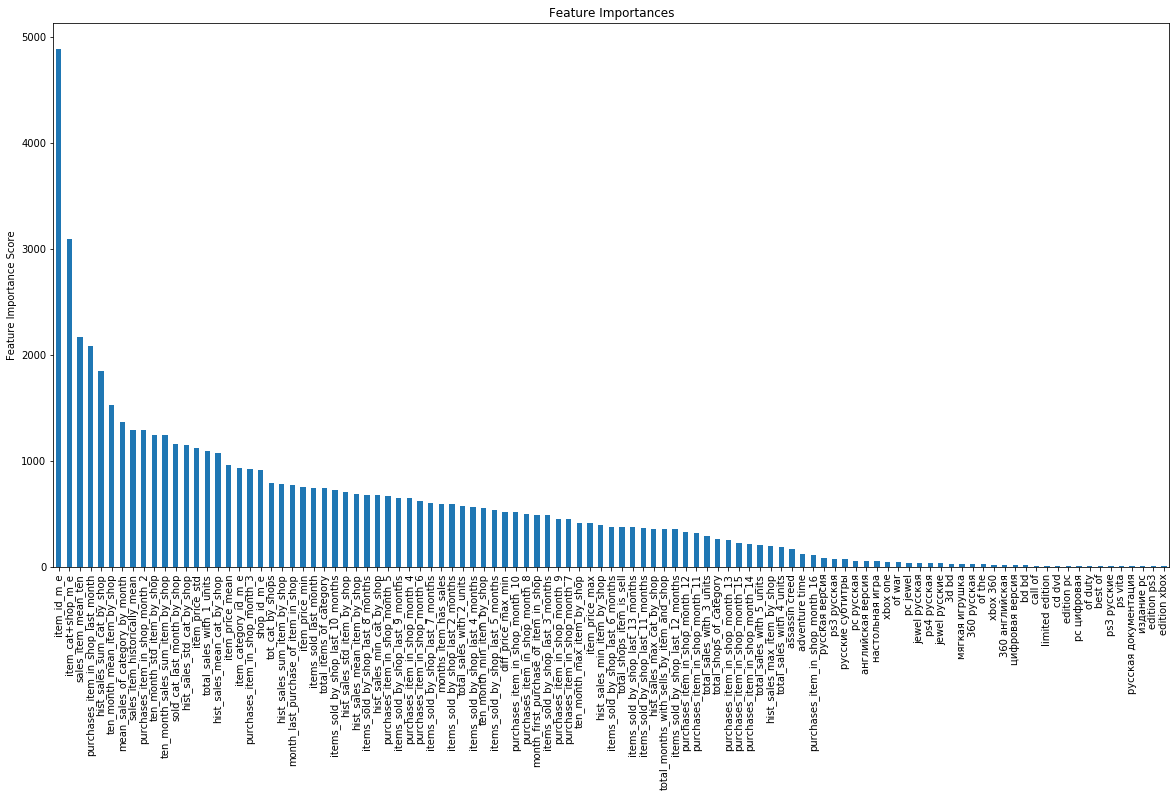

In [55]:
plt.figure(figsize=(20,10))
feat_imp = pd.Series(xgboost.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [56]:
feat_imp

item_id_m_e                                 4886
item_cat+shop_m_e                           3088
sales_item_mean_ten                         2167
purchases_item_in_shop_last_month           2079
hist_sales_sum_cat_by_shop                  1847
ten_month_mean_item_by_shop                 1528
mean_sales_of_category_by_month             1364
sales_item_historically_mean                1289
purchases_item_in_shop_month_2              1286
ten_month_std_item_by_shop                  1244
ten_month_sales_sum_item_by_shop            1238
sold_cat_last_month_by_shop                 1152
hist_sales_std_cat_by_shop                  1151
item_price_std                              1122
total_sales_with_1_units                    1093
hist_sales_mean_cat_by_shop                 1076
item_price_mean                              958
item_category_id_m_e                         929
purchases_item_in_shop_month_3               921
shop_id_m_e                                  908
tot_cat_by_shops    

# RANDOM FOREST & MODELS THAT DOESN'T ACCEPT NA VALUES

### Analyze NA values

In [157]:
df.isna().sum()

shop_id                                         0
item_id                                         0
label                                           0
item_category_id                                0
hist_sales_sum_cat_by_shop                      0
hist_sales_mean_cat_by_shop                     0
hist_sales_std_cat_by_shop                    907
hist_sales_min_cat_by_shop                      0
hist_sales_max_cat_by_shop                      0
sold_cat_last_month_by_shop                     0
total_shops_of_category                         2
total_items_of_category                         2
mean_sales_of_category_by_month                 2
tot_cat_by_shops                                0
items_sold_last_month                           0
items_sold_by_shop_last_2_months                0
items_sold_by_shop_last_3_months                0
items_sold_by_shop_last_4_months                0
items_sold_by_shop_last_5_months                0
items_sold_by_shop_last_6_months                0


In [158]:
# For item_price features, take main of category
grouped = df.groupby("item_category_id").agg({"item_price_max":"mean", "item_price_mean":"mean", "item_price_min":"mean", "item_price_std":"mean", "diff_price_max_min":"mean"}).reset_index()
grouped.head()

,item_category_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min
0,2,3240.127737,2704.384533,1976.975036,276.215121,1263.152701
1,3,2879.226732,2277.276775,1576.107446,236.696546,1303.119286
2,4,399.000000,380.799624,98.000000,53.523906,301.000000
3,5,712.668966,620.084411,264.430069,70.666692,448.238897
4,6,3068.554455,2169.018964,1282.533208,346.132264,1786.021248


In [159]:
df["id"] = [x for x in range(len(df))]
df.head()

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units,item_category_id_m_e,item_id_m_e,shop_id_m_e,1с аудиокниги,1с образовательная,1с познавательная,1с школа,2cd digipack,360 английская,360 русская,3d bd,adventure time,assassin creed,bd bd,best of,call of,cd digipack,cd dvd,cd jewel,dvd box,edition pc,edition ps3,edition xbox,essentials psp,jewel русская,jewel русские,limited edition,mp3 cd,of duty,of the,of war,pc jewel,pc русская,pc цифровая,ps move,ps vita,ps3 английская,ps3 русская,ps3 русские,ps4 русская,xbox 360,xbox one,английская версия,издание pc,мягкая игрушка,настольная игра,образовательная коллекция,познавательная коллекция,русская версия,русская документация,русские субтитры,только для,цифровая версия,id
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,1.058596,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875,16.0,32.0,905.0,100.0,45.0,18.0,12.0,1.475649,1.601418,1.632068,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,31,2.0,37,6986.0,211.696970,64.988213,102.0,372.0,111.0,57.0,1768.0,1.058596,63.0,1587.0,1550.0,1456.0,1504.0,1434.0,1568.0,1.20,6.0,0.447214,2.0,1.0,2.875000,46.0,4.224926,18.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,32.0,1.0,16.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875,16.0,32.0,905.0,100.0,45.0,18.0,12.0,1.475649,1.601418,1.580137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,18,31,1.0,37,4141.0,125.484848,46.270348,62.0,224.0,84.0,57.0,1768.0,1.058596,62.0,1316.0,1152.0,983.0,1147.0,1189.0,1168.0,1.25,5.0,0.500000,2.0,1.0,3.230769,42.0,5.464337,21.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,31.0,1.0,13.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875,16.0,32.0,905.0,100.0,45.0,18.0,12.0,1.475649,1.601418,1.562808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,21,31,1.0,37,5917.0,179.303030,59.800441,72.0,348.0,123.0,57.0,1768.0,1.058596,61.0,1732.0,1543.0,1680.0,1597.0,1551.0,1752.0,1.40,7.0,0.547723,2.0,1.0,2.500000,40.0,3.405877,14.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,31.0,1.0,16.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875,16.0,32.0,905.0,100.0,45.0,18.0,12.0,1.475649,1.601418,1.641545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,25,31,1.0,37,18208.0,551.757576,155.589811,302.0,873.0,302.0,57.0,1768.0,1.058596,65.0,4562.0,4259.0,4250.0,4547.0,4506.0,4862.0,2.60,13.0,1.140175,4.0,1.0,3.720000,93.0,7.208329,37.0,1.0,0.0,3.0,0.0,0

In [160]:
df_item_price_na = df[df.item_price_max.isna()]
df_item_price_na.drop(columns=["item_price_max", "item_price_mean", "item_price_std", "item_price_min", "diff_price_max_min"], inplace=True)
print(len(df_item_price_na))

8400


/home/urielkelman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [161]:
df_item_price_na = pd.merge(df_item_price_na, grouped, on="item_category_id", how="inner")
print(len(df_item_price_na))

df_item_price_na = df_item_price_na[df.columns]
print(len(df_item_price_na))
df_item_price_na.columns == df.columns

8400
8400


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [162]:
print(len(df))
df = df_item_price_na.append(df).drop_duplicates(subset=["id"], keep="first").drop(columns=["id"])
print(len(df))
df.head()

126961
126961


,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units,item_category_id_m_e,item_id_m_e,shop_id_m_e,1с аудиокниги,1с образовательная,1с познавательная,1с школа,2cd digipack,360 английская,360 русская,3d bd,adventure time,assassin creed,bd bd,best of,call of,cd digipack,cd dvd,cd jewel,dvd box,edition pc,edition ps3,edition xbox,essentials psp,jewel русская,jewel русские,limited edition,mp3 cd,of duty,of the,of war,pc jewel,pc русская,pc цифровая,ps move,ps vita,ps3 английская,ps3 русская,ps3 русские,ps4 русская,xbox 360,xbox one,английская версия,издание pc,мягкая игрушка,настольная игра,образовательная коллекция,познавательная коллекция,русская версия,русская документация,русские субтитры,только для,цифровая версия
0,4,1121,1.0,55,4729.0,147.781250,42.565876,28.0,229.0,121.0,55.0,2271.0,1.02869,61.0,901.0,844.0,791.0,815.0,797.0,955.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,323.006419,297.063306,183.648136,23.020313,139.358283,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.298209,2.578759,1.430398,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,1121,1.0,55,4702.0,151.677419,33.212836,95.0,213.0,142.0,55.0,2271.0,1.02869,60.0,1284.0,994.0,940.0,960.0,883.0,1105.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,323.006419,297.063306,183.648136,23.020313,139.358283,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.298209,2.578759,1.566739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,1121,2.0,55,11726.0,366.437500,96.838055,164.0,623.0,213.0,55.0,2271.0,1.02869,63.0,1550.0,1456.0,1504.0,1434.0,1568.0,1884.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,323.006419,297.063306,183.648136,23.020313,139.358283,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.298209,2.578759,1.580137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,1121,2.0,55,6768.0,211.500000,50.916757,119.0,327.0,132.0,55.0,2271.0,1.02869,60.0,1405.0,1300.0,1229.0,1100.0,1189.0,1398.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,323.006419,297.063306,183.648136,23.020313,139.358283,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.298209,2.578759,1.734186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,1121,2.0,55,2209.0,71.258065,17.355053,40.0,110.0,54.0,55.0,2271.0,1.02869,57.0,442.0,429.0,431.0,394.0,496.0,538.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,323.006419,297.063306,183.648136,23.020313,139.358283,NaN,NaN,NaN,0.0,0.0,0.0,0.

In [163]:
df["hist_sales_std_cat_by_shop"] = df["hist_sales_std_cat_by_shop"].fillna(0)
df["hist_sales_std_item_by_shop"] = df["hist_sales_std_item_by_shop"].fillna(0)
df["month_last_purchase_of_item_in_shop"] = df["month_last_purchase_of_item_in_shop"].fillna(-1)
df["month_first_purchase_of_item_in_shop"] = df["month_first_purchase_of_item_in_shop"].fillna(-1)
df["item_price_std"] = df["item_price_std"].fillna(0)
df["total_shops_item_is_sell"] = df["total_shops_item_is_sell"].fillna(0)
df["total_shops_of_category"] = df["total_shops_of_category"].fillna(0)
df["total_items_of_category"] = df["total_items_of_category"].fillna(0)

df["mean_sales_of_category_by_month"] = df["mean_sales_of_category_by_month"].fillna(0)
df["ten_month_mean_item_by_shop"] = df["ten_month_mean_item_by_shop"].fillna(0)
df["ten_month_sales_sum_item_by_shop"] = df["ten_month_sales_sum_item_by_shop"].fillna(0)
df["ten_month_std_item_by_shop"] = df["ten_month_std_item_by_shop"].fillna(0)
df["ten_month_max_item_by_shop"] = df["ten_month_max_item_by_shop"].fillna(0)
df["ten_month_min_item_by_shop"] = df["ten_month_min_item_by_shop"].fillna(0)
df["sales_item_historically_mean"] = df["sales_item_historically_mean"].fillna(0)
df["sales_item_mean_ten"] = df["sales_item_mean_ten"].fillna(0)

In [164]:
df.isna().sum()

shop_id                                     0
item_id                                     0
label                                       0
item_category_id                            0
hist_sales_sum_cat_by_shop                  0
hist_sales_mean_cat_by_shop                 0
hist_sales_std_cat_by_shop                  0
hist_sales_min_cat_by_shop                  0
hist_sales_max_cat_by_shop                  0
sold_cat_last_month_by_shop                 0
total_shops_of_category                     0
total_items_of_category                     0
mean_sales_of_category_by_month             0
tot_cat_by_shops                            0
items_sold_last_month                       0
items_sold_by_shop_last_2_months            0
items_sold_by_shop_last_3_months            0
items_sold_by_shop_last_4_months            0
items_sold_by_shop_last_5_months            0
items_sold_by_shop_last_6_months            0
ten_month_mean_item_by_shop                 0
ten_month_sales_sum_item_by_shop  

### Split, train and save model

## RANDOM FOREST

In [165]:
features = df

features.drop(columns=['shop_id', 'item_id', 'item_category_id'], inplace=True)

target_col = "label"
predictors = [x for x in features.columns if x != target_col]

jb.dump(predictors, "model_parameters/predictors_rf.pkl")

predictors

['hist_sales_sum_cat_by_shop',
 'hist_sales_mean_cat_by_shop',
 'hist_sales_std_cat_by_shop',
 'hist_sales_min_cat_by_shop',
 'hist_sales_max_cat_by_shop',
 'sold_cat_last_month_by_shop',
 'total_shops_of_category',
 'total_items_of_category',
 'mean_sales_of_category_by_month',
 'tot_cat_by_shops',
 'items_sold_last_month',
 'items_sold_by_shop_last_2_months',
 'items_sold_by_shop_last_3_months',
 'items_sold_by_shop_last_4_months',
 'items_sold_by_shop_last_5_months',
 'items_sold_by_shop_last_6_months',
 'ten_month_mean_item_by_shop',
 'ten_month_sales_sum_item_by_shop',
 'ten_month_std_item_by_shop',
 'ten_month_max_item_by_shop',
 'ten_month_min_item_by_shop',
 'hist_sales_mean_item_by_shop',
 'hist_sales_sum_item_by_shop',
 'hist_sales_std_item_by_shop',
 'hist_sales_max_item_by_shop',
 'hist_sales_min_item_by_shop',
 'purchases_item_in_shop_last_month',
 'purchases_item_in_shop_month_2',
 'purchases_item_in_shop_month_3',
 'purchases_item_in_shop_month_4',
 'purchases_item_in_sh

In [166]:
X = features[predictors]
y = features[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [167]:
'''random_grid = {'bootstrap': [True, False],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}'''

"random_grid = {'bootstrap': [True, False],\n 'min_samples_leaf': [1, 2, 4],\n 'min_samples_split': [2, 5, 10]}"

In [168]:
regressor = RandomForestRegressor(n_jobs=4, random_state=27, criterion="mse", n_estimators=2000, max_features='auto', max_depth=8, min_samples_split=2, min_samples_leaf=4)

In [169]:
# clf = RandomizedSearchCV(regressor, random_grid, random_state=27, scoring='neg_mean_squared_error', n_jobs=4, verbose=3)

In [170]:
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=4,
                      oob_score=False, random_state=27, verbose=0,
                      warm_start=False)

In [46]:
# rfRegressor = clf.best_estimator_ 

In [171]:
predictions_train = regressor.predict(X_train)

root_mean_squared_error(y_train, predictions_train)

1.0802337882360558

In [172]:
predictions = regressor.predict(X_test)

root_mean_squared_error(y_test, predictions)

1.1509605297535048

In [173]:
jb.dump(regressor, "models/22-rf_bow_2ngrams.pkl")

['models/22-rf_bow_2ngrams.pkl']

## XGBOOST without nans

In [34]:
features = df

optimal_parameters = jb.load("model_parameters/xgb_parameters.pkl")
optimal_parameters

F, f = train_test_split(features, test_size = 0.1, random_state=42)
print("Train size:", len(F))
print("Test size:", len(f))

Train size: 114264
Test size: 12697


Predictors are: ['shop_id', 'item_id', 'item_category_id', 'hist_sales_sum_cat_by_shop', 'hist_sales_mean_cat_by_shop', 'hist_sales_std_cat_by_shop', 'hist_sales_min_cat_by_shop', 'hist_sales_max_cat_by_shop', 'sold_cat_last_month_by_shop', 'total_shops_of_category', 'total_items_of_category', 'mean_sales_of_category_by_month', 'tot_cat_by_shops', 'items_sold_last_month', 'items_sold_by_shop_last_2_months', 'items_sold_by_shop_last_3_months', 'items_sold_by_shop_last_4_months', 'items_sold_by_shop_last_5_months', 'items_sold_by_shop_last_6_months', 'ten_month_mean_item_by_shop', 'ten_month_sales_sum_item_by_shop', 'ten_month_std_item_by_shop', 'ten_month_max_item_by_shop', 'ten_month_min_item_by_shop', 'hist_sales_mean_item_by_shop', 'hist_sales_sum_item_by_shop', 'hist_sales_std_item_by_shop', 'hist_sales_max_item_by_shop', 'hist_sales_min_item_by_shop', 'purchases_item_in_shop_last_month', 'purchases_item_in_shop_month_2', 'purchases_item_in_shop_month_3', 'purchases_item_in_shop_mon

/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
RMSE : 0.9797795046068741


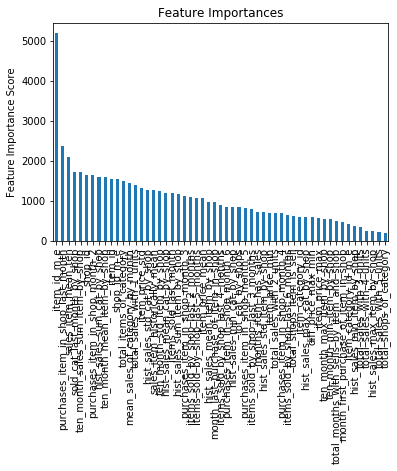

In [36]:
target_col = "label"

predictors = [x for x in F.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost = XGBRegressor(
 learning_rate=0.01,
 n_estimators=2000,
 max_depth=optimal_parameters["max_depth"],
 min_child_weight=optimal_parameters["min_child_weight"],
 gamma=optimal_parameters["gamma"],
 subsample=optimal_parameters["subsample"],
 colsample_bytree=optimal_parameters["colsample_by_tree"],
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost, F, predictors, target_col)

In [37]:
test_predictions = xgboost.predict(f[predictors])

print(root_mean_squared_error(f[target_col], test_predictions))

jb.dump(xgboost, "models/17-xgb_with_non_nans.pkl")

1.0595381113190494


['models/17-xgb_with_non_nans.pkl']